# IOD_amplitude: Variability of SST Anomalies in the Eastern and Western Tropical Indian Ocean
Computes the standard deviation of the Dipole Mode Index Dipole Mode Index (gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N)).
To evaluate the amplitude of variability of the Indian Ocean Dipole (IOD).

# Datasets Used for Amplitude Comparison
The following reference datasets are used to evaluate the amplitude of IOD-related SST anomalies in model simulations:

TropFlux (1979–2018): The primary dataset for comparison, offering high-quality surface fluxes and anomalies tailored for tropical climate analysis.
Additional datasets include:

20CRv2 (1871–2012): A long-term reanalysis dataset reconstructing global atmospheric conditions using surface pressure observations.
ERA-Interim (1979–2018): A high-resolution reanalysis product providing consistent estimates of atmospheric and surface variables.
ERSSTv5 (1854–2018): A globally gridded dataset optimised for long-term SST anomaly analysis and ENSO studies.
HadISST (1870–2018): A comprehensive dataset of historical SST and sea ice observations combined with reconstructions.
NCEP2 (1979–2018): A second-generation reanalysis dataset delivering improved global atmospheric and surface data.

In [6]:
from esmvalcore.dataset import Dataset

In [7]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

In [8]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/esmvalcore/preprocessor/_io.py:265: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  calendar_index = int(


In [9]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris
import numpy as np

import matplotlib.pyplot as plt
import iris.quickplot as qplt
# import cftime

In [10]:
# diag level 2 & 3?
def prepoc(cube):
    iod_trop = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}

    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **iod_trop)
    cube = anomalies(cube,period='monthly')

    cube = axis_statistics(cube,axis='y', operator='mean')

    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube
def prepoc3(cube): # extents and no axis statistics
    
    iod_trop = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}

    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **iod_trop)
    cube = anomalies(cube,period='monthly')
    # compute temporal standard deviation
    cube = climate_statistics(cube, operator="std_dev", period="full")
    return cube

## sst_std for diag 1
def prepoc_one(cube):
    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    cube = convert_units(cube, units="degC")
    # cube = mask_landsea(cube, mask_out="land")
    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    # remove seasonal cycle
    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')
    #detrend
    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')

    #dmi = iod_west - iod_east
    cube_dmi = cube_west - cube_east
    # compute temporal standard deviation
    cube = climate_statistics(cube_dmi, operator="std_dev", period="full")
    return cube

    
def compute(obs, mod):
    return abs((mod-obs)/obs)*100

In [11]:
model_datasets_prep = {name: prepoc_one(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep = {name: prepoc_one(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along first dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2140: IrisVagueMetadataWarning: Collapsin

# Diagnostic Level 1
The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0.75, 0.8, '* observation')

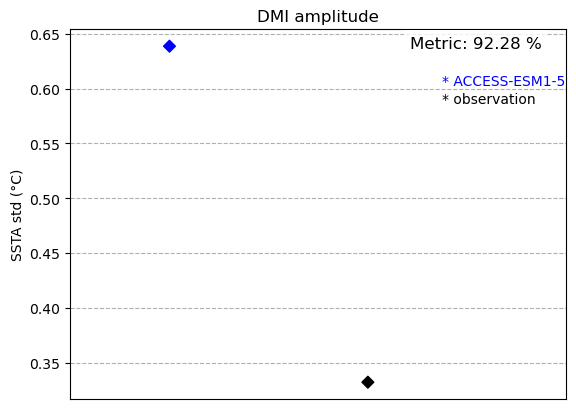

In [12]:
# plot
metric = [model_datasets_prep["ACCESS-ESM1-5"].data.item(), obs_datasets_prep["HadISST"].data.item()]

plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('SSTA std (°C)')
plt.grid(linestyle='--', axis='y')
plt.title('DMI amplitude')

metricval = compute(metric[1],metric[0])

plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-ESM1-5', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)

Figure 1: Standard deviation of the Dipole Mode Index, representing the variability of the Indian Ocean Dipole. Black markers indicate the reference data, while blue markers represent the model. The derived metric is the absolute relative difference, calculated as: abs ( ( model − ref ) / ref ) × 100 abs((model−ref)/ref)×100.

# Diagnostic Level 2¶

The second level shows the zonal structure of the IOD amplitude: the standard deviation of the anomalies along the equatorial Indian Ocean.

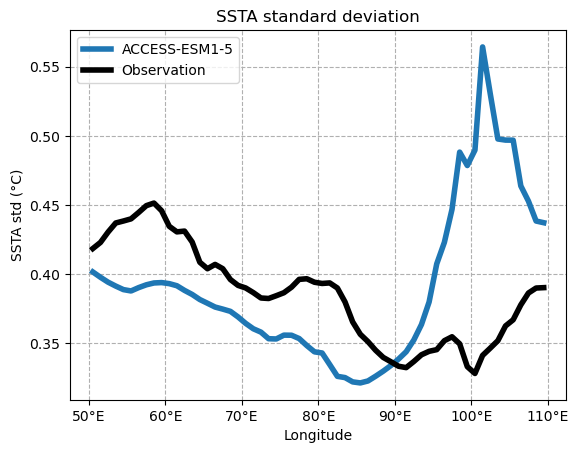

In [13]:

## diag 2 plot
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

qplt.plot(model_datasets_prep2["ACCESS-ESM1-5"], label="ACCESS-ESM1-5", linewidth=4)
qplt.plot(obs_datasets_prep2["HadISST"], color='black', label='Observation', linewidth=4)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('SSTA std (°C)')
plt.title('SSTA standard deviation')
plt.grid(linestyle='--')
plt.legend()

Figure 2: Zonal structure of the standard deviation of sea surface temperature anomalies (SSTA) in the equatorial Indian Ocean (averaged between 10°S and 10°N). The figure highlights the model's tendency to... The black curve represents the reference data, while the blue curve corresponds to the model output.

# Diagnostic level 3

In [14]:

model_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: prepoc3(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=

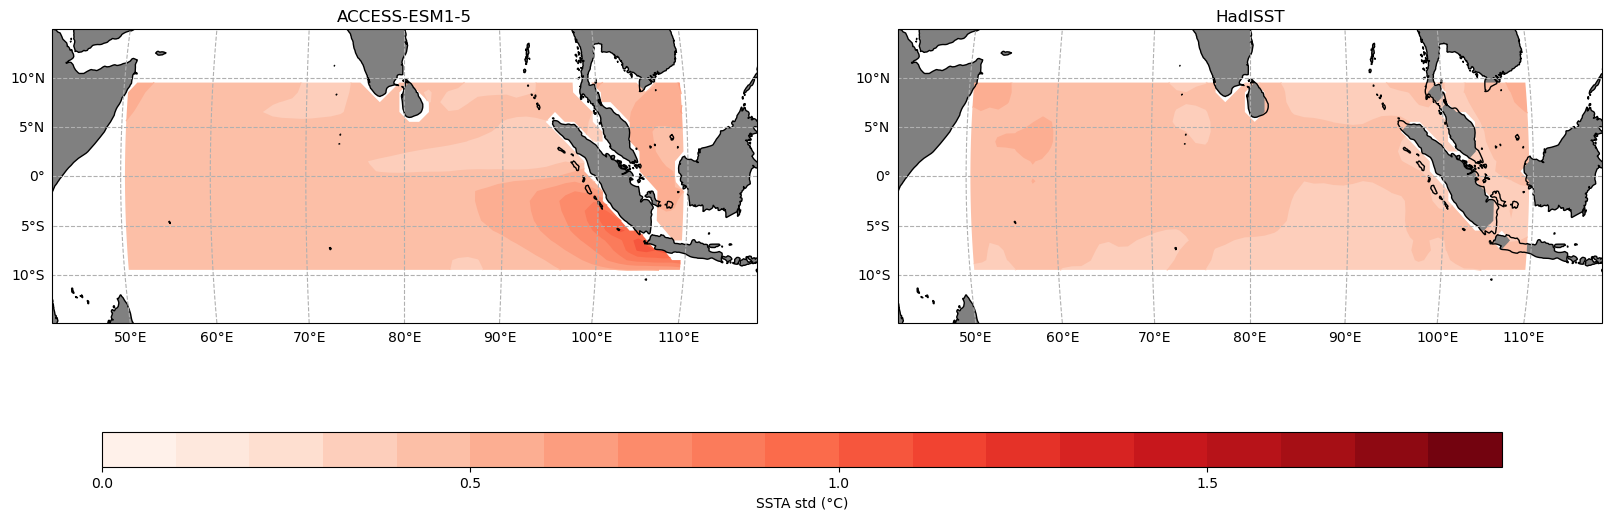

In [18]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=80.0)
i =121
process = {**model_datasets_prep3, "HadISST":obs_datasets_prep3["HadISST"]}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(0,2,0.1), cmap='Reds')

    ax1.set_extent([40, 120, -15, 15], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(0,2,0.5))
cbar.set_label('SSTA std (°C)')